# ANALYSIS 3 : POINT OF INTEREST AS THE ONE WITH MAXIMUM NUMBER OF REVIEWS ON AMAZON

In [11]:
# importing all the required Libraries
import glob
import json
import csv
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import calendar
import collections
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Creating a path for Review file i.e. input Data.
file=glob.glob('E:\CapstoneProject\Prime_Pantry.json\Prime_Pantry.json')

Cleaning of 'Prime_Pantry.json' file and importing the data as pandas DataFrame.

In [21]:
# Reading a multiple json files from a single json file 'ReviewSample.json'.
review=[]
with open(file[0]) as data_file:
    data=data_file.read()
    for i in data.split('\n'):
        review.append(i)
        
# Making a list of Tuples containg all the data of json files.
reviewDataframe=[]
for x in review:
    try:
        jdata=json.loads(x)
        reviewDataframe.append((jdata['overall'],jdata['verified'],jdata['reviewTime'],jdata['reviewerID'],jdata['asin'],jdata['reviewerName'],jdata['reviewText'],jdata['summary'],jdata['unixReviewTime'])) 
    except:
        pass
    
# Creating a dataframe using the list of Tuples got in the previous step.
dataset=pd.DataFrame(reviewDataframe,columns=['Overall','Verified','Review_Time','Reviewer_ID','Asin','Reviewer_Name','Review_Text','Summary','Unix_Review_Time'])

Grouping on 'Reviewer_ID' and getting the count of reviews.

In [22]:
temp=dataset.groupby('Reviewer_ID')['Asin'].count().reset_index()
temp=temp.rename(columns={'Asin':'No_Of_Reviews'})

Sorting in Descending order of 'No_Of_Reviews'

In [24]:
Point_ofInterest=temp.sort_values('No_Of_Reviews',ascending=False)

In [25]:
Point_ofInterest.head()

,Reviewer_ID,No_Of_Reviews
223263,AMMNGUJK4HQJ5,202
141235,A35Q0RBM3YNQNF,197
219766,AKPG8VQBS0MWR,149
243072,AXK37UZY8UPYP,146
6474,A13J2PGKNMJG1K,146


# DISTRIBUTION OF REVIEWS FOR 'Mary' BASED ON OVERALL RATING (REVIEWER_ID : A2FYW9VZ0AMXKY).

Only taking those review which is posted by 'Mary'.

In [27]:
POI=dataset[dataset.Reviewer_ID == 'A2FYW9VZ0AMXKY']

Function to give positive, negative and neutral status based on Overall Rating.

In [28]:
def ReviewCategory(score):
    if score >= 4:
        return 'pos'
    elif (score <= 2) & (score > 0):
        return 'neg'
    else:
        return 'neu'

Calling function 'ReviewCategory()' for each row of DataFrame.

In [30]:
POI['Category']=POI['Overall'].apply(lambda x: ReviewCategory(x))

Grouping on 'Category' which we got in previous step and getting the count of reviews.

In [32]:
CategoryCount=POI.groupby('Category')['Reviewer_ID'].count().reset_index()
CategoryCount=CategoryCount.rename(columns={'Reviewer_ID':'Count'})

In [33]:
CategoryCount

,Category,Count
0,neg,1
1,pos,33


Bar Plot for Category V/S Count.

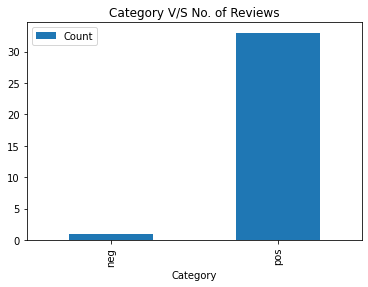

In [34]:
CategoryCount.plot(x="Category",y="Count",kind="bar",title="Category V/S No. of Reviews")
plt.show()

# DISTRIBUTION OF REVIEWS OVER THE YEARS FOR 'Mary'

In [35]:
# Converting the data type of 'Review_Time' column in the Dataframe 'POI' to datetime format.
POI['Review_Time']= pd.to_datetime(POI['Review_Time'])

# Creating an Addtional column as 'Month' in Datatframe 'POI' for Month by taking the month part of 'Review_Time' column.
POI['Month']=POI['Review_Time'].dt.month

# Creating an Addtional column as 'Year' in Datatframe 'POI' for Year by taking the year part of 'Review_Time' column.
POI['Year']=POI['Review_Time'].dt.year

# Creating an Addtional column as 'Day' in Datatframe 'POI' for Year by taking the year part of 'Review_Time' column.
POI['Day']=POI['Review_Time'].dt.day

Grouping on 'Year' which we got in previous step and getting the count of reviews.

In [36]:
YearlyCount=POI.groupby('Year')['Reviewer_ID'].count().reset_index()
YearlyCount=YearlyCount.rename(columns={'Reviewer_ID':'No_Of_Reviews'})

In [37]:
YearlyCount.head()

,Year,No_Of_Reviews
0,2015,34


Bar Plot to get trend over the years for Reviews Written by 'Mary'

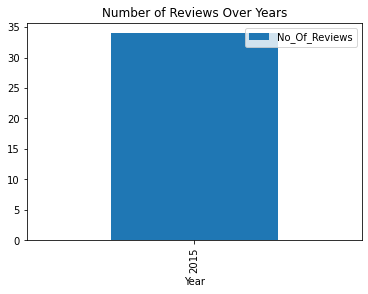

In [39]:
YearlyCount.plot(x="Year",y="No_Of_Reviews",kind="bar",title="Number of Reviews Over Years")
plt.show()

# PERCENTAGE DISTRIBUTION OF NEGATIVE REVIEWS FOR 'Mary', SINCE THE COUNT OF REVIEWS IS DROPPING POST YEAR 2009

Taking the count of negative reviews over the years.

In [40]:
neg=POI[POI.Category == 'neg']
neg_Year=neg.groupby('Year')['Reviewer_ID'].count().reset_index()
neg_Year=neg_Year.rename(columns={'Reviewer_ID':'No_Of_Neg_Reviews'})

Negative reviews over the year by 'Mary'

In [41]:
neg_Year

,Year,No_Of_Neg_Reviews
0,2015,1


Merging 2 Dataframe for mapping and then calculating the Percentage of Negative reviews for each year.

In [42]:
neg_Percentage=pd.merge(neg_Year,YearlyCount,on='Year',how='inner')
neg_Percentage['Percentage']=(neg_Percentage['No_Of_Neg_Reviews']/neg_Percentage['No_Of_Reviews'])*100

In [43]:
neg_Percentage

,Year,No_Of_Neg_Reviews,No_Of_Reviews,Percentage
0,2015,1,34,2.941176


Bar Plot for Year V/S Negative Reviews Percentage

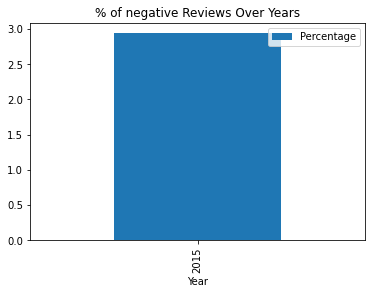

In [44]:
neg_Percentage.plot(x="Year",y="Percentage",kind="bar",title="% of negative Reviews Over Years")
plt.show()

# LEXICAL DENSITY DISTRIBUTION OVER THE YEAR FOR REVIEWS WRITTEN BY 'Mary'

To Generate a word corpus following steps are performed inside the function 'create_Word_Corpus(df)'

Step 1 :- Iterating over the 'summary' section of reviews such that we only get important content of a review.
Step 2 :- Converting the content into Lowercase.
Step 3 :- Using nltk.tokenize to get words from the content.
Step 4 :- Using string.punctuation to get rid of punctuations.
Step 5 :- Using stopwords from nltk.corpus to get rid of stopwords.
Step 6 :- tagging of Words using nltk and only allowing words with tag as ("NN","JJ","VB","RB").
Step 7 :- Finally forming a word corpus and returning the word corpus.

In [45]:
# To Generate a word corpus 
def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["Review_Text"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = nltk.pos_tag(tokens)
        finalwords=[]
        for x in tokens:
            if x[1].startswith(("NN","JJ","VB","RB")):
                finalwords.append(x[0])
        for words in finalwords:
            words_corpus = words_corpus + words + ' '
    return words_corpus

# Plot a cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

Generate a WordCloud image

In [48]:
# Generate a word cloud image
Mary_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(POI))

In [47]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pratik Patil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

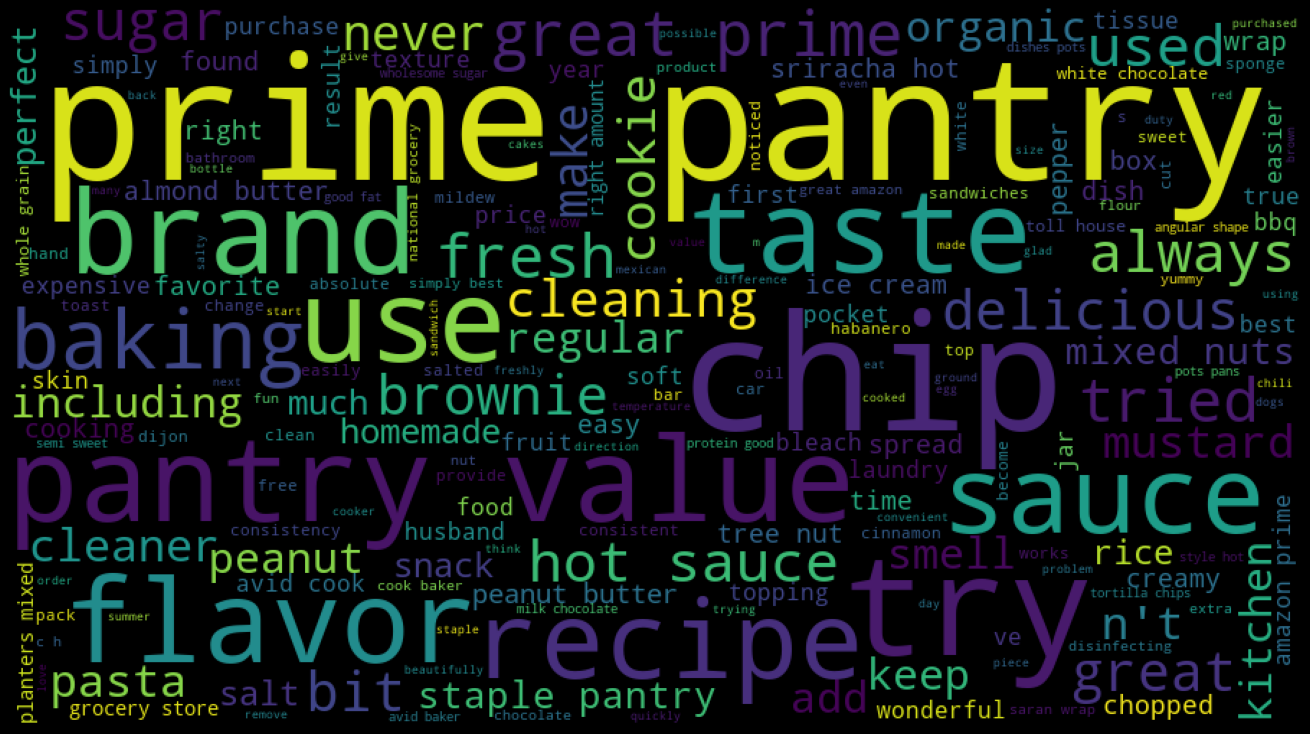

<Figure size 432x288 with 0 Axes>

In [49]:
plot_Cloud(Mary_wordcloud)

# NUMBER OF DISTINCT PRODUCTS REVIEWED BY 'MARY' ON AMAZON

In [50]:
len(POI['Asin'].unique())

30

# PRODUCTS REVIEWED BY 'MARY'.

In [52]:
# Creating a path for Review file i.e. input Data.
file2=glob.glob('E:\CapstoneProject\meta_Prime_Pantry.json\meta_Prime_Pantry.json')

In [53]:
# reading a multiple json files from a single json file 'ProductSample.json'.
product=[]
with open(file2[0]) as data_file:
    data=data_file.read()
    for i in data.split('\n'):
        product.append(i)
        
# Firstly cleaning the data by converting files into proper json format files by some replacements and then Making a list of Tuples containg all the data of json files.        
productDataframe=[]
for x in product:
    try:
        y=x.replace("'",'"')
        jdata=json.loads(y)
        productDataframe.append((jdata['asin'],jdata['title'])) 
    except:
        pass
    
# Creating a dataframe using the list of Tuples got in the previous step.     
Product_dataset=pd.DataFrame(productDataframe,columns=['Asin','Title'])

Mapping 'Product_dataset' with 'POI' to get the products reviewed by 'Mary'.

In [54]:
Products_Reviewed=pd.merge(POI,Product_dataset,on="Asin",how="left")

In [56]:
Products_Reviewed=Products_Reviewed[['Asin','Title','Overall']]

In [57]:
Products_Reviewed.head()

,Asin,Title,Overall
0,B0000DIWNI,"Saran Premium Plastic Wrap, 100 Sq Ft",5.0
1,B000Q68WSA,"Morton Coarse Kosher Salt Box, 48 Ounce",5.0
2,B000QV54YK,"Lundberg Family Farms Organic Basmati Rice, Ca...",5.0
3,B000RK4BFI,NaN,5.0
4,B0010XV5T6,"Wholesome Sweeteners Organic Sugar, 64 oz.",5.0
